In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import pathmagic
from tools.project import proj_dir

In [2]:
#!ls -lt {proj_dir("models", "ddff_mdff")}

In [3]:
#!rsync -auv --progress atbeetz25:Documents/master-thesis/models/ddff_mdff {proj_dir("models")} \
    #--include="*/" --include='*.txt' --include='*.json' --include='*train_stats.pkl' --exclude='*'
#!rsync -auv --progress atbeetz25:Documents/master-thesis/models/ddff_mdff {proj_dir("models")}
#!rsync -auv --progress atbeetz25:Documents/master-thesis/models/ddff_mdff/{model_name} {proj_dir("models", "ddff_mdff")}

In [4]:
#model_name = "model-20181223-143416/model_8"
#eval_script = proj_dir("scripts", "eval_model.py")
#%run {eval_script} -r --mtype ddff_dummy test_model/model_1

#model_name = "model-20181226-012520/model_1"

#model_name = "model-20181222-153829/model_1" #best
#model_name = "model-20181222-153829/model_2"
#model_name = "model-20181222-013239/model_4"
#model_name = "model-20181223-034935/model_3"

In [3]:
import trainer.model_loader
from trainer.model_loader import ModelLoader

load_checkpoint = True

def slurm_sync(file):
    rel_cur_dir = os.path.relpath(os.getcwd(), os.path.expanduser("~"))    

    if not os.path.isfile(file):
        if not os.path.exists(os.path.dirname(file)):
            os.makedirs(os.path.dirname(file))

        !rsync -auv --progress atbeetz25:{os.path.join(rel_cur_dir, file)} {file}
    

if load_checkpoint:
    #model_name, epoch, dataset, data_type = "test_model", 4, "DDFFData", "test"
    #model_name, epoch, dataset, data_type = "mdff_best", 200, "MdffH5Data", "test"
    #model_name, epoch, dataset, data_type = "ddff_best", 185, "MdffH5Data", "test"
    #model_name, epoch, dataset, data_type = "ddff_best", 185, "DDFFData", "test"
    
    model_name, epoch, dataset, data_type = "model_73157", 200, "SuperSlomoData", "test"
    
    model_loader = ModelLoader(proj_dir("models", "ddff_mdff"), model_name)
    
    checkpoint_file = model_loader.model_filepath("checkpoint", epoch=epoch)
    eval_file = model_loader.model_filepath("eval", epoch=epoch, data_name=dataset, data_type=data_type)
    
    slurm_sync(checkpoint_file)
    slurm_sync(eval_file)
        
    checkpoint = model_loader.load("checkpoint", epoch=epoch)
    
    #model = checkpoint["model"]
    stats = checkpoint["stats"]
    
    eval_data = model_loader.load("eval", epoch=epoch, data_name=dataset, data_type=data_type)
else:
    model_path = os.path.join(proj_dir("models", "ddff_mdff"), model_name)

    model_loader = ModelLoader(model_path)
    model_stats = model_loader.load_all({"desc": None, "train_stats": None})
    
model_params = model_loader.load("params")

receiving incremental file list
checkpoint_epoch_0200.pth
    475,404,469 100%    3.00MB/s    0:02:31 (xfr#1, to-chk=0/1)

sent 43 bytes  received 475,520,658 bytes  3,097,854.73 bytes/sec
total size is 475,404,469  speedup is 1.00
receiving incremental file list
rsync: change_dir "/usr/stud/galim//Documents/master-thesis/code/mt-project/notebooks/../../../models/ddff_mdff/model_73157/eval" failed: No such file or directory (2)

sent 8 bytes  received 181 bytes  75.60 bytes/sec
total size is 0  speedup is 0.00
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1668) [Receiver=3.1.2]
rsync: [Receiver] write error: Broken pipe (32)


In [6]:
import json
import os
import net.ddff_net
from trainer.model_loader import ModelLoader


print("Model")
print(json.dumps(model_loader.load("params"), indent=4))

Model
null


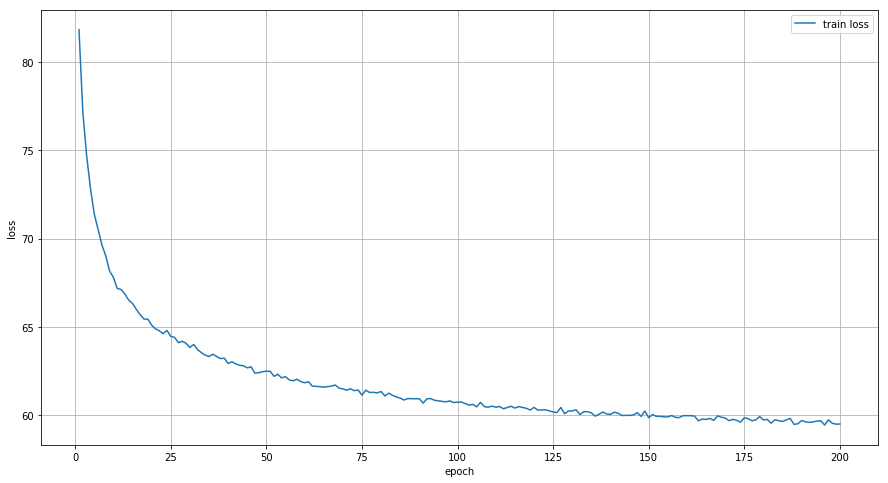

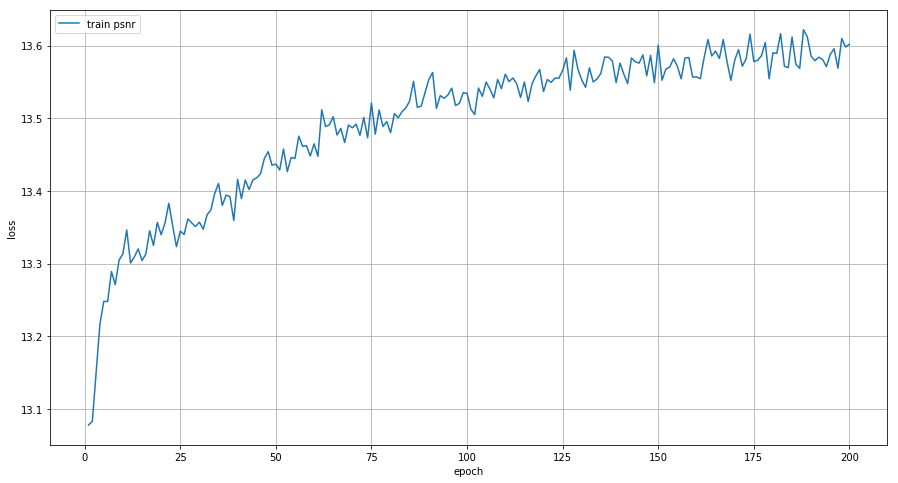

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_train_stats(train_stats, ymax=None, losses=None):
    num_epochs = len(train_stats["train"]["loss"])
    #batch_size = 2

    plt.figure(figsize=(15, 8))

    #for dt in ["train", "val"]:
    for dt in ["train"]:
        for label, values in train_stats[dt].items():
            if losses is None or label in losses:
                data_x = np.arange(1, num_epochs+1)
                data_y = np.array(values)

                #if dt == "train":
                    #data_y /= batch_size

                plt.plot(data_x, data_y, label=" ".join([dt, label]))

    plt.grid(b=True)
    plt.legend()
    #plt.ylabel('loss (Masked MSE)')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    
    if ymax is not None:
        plt.ylim(bottom=0, top=ymax)
    
    plt.show()
    

visualize_train_stats(stats, losses=["loss"])
visualize_train_stats(stats, losses=["psnr"])
#visualize_train_stats(stats, ymax=0.05)
#visualize_train_stats(stats, ymax=0.01)
#visualize_train_stats(stats, ymax=0.002)

In [8]:
#test_loss = model_stats["eval"]["loss"]
#print("Test loss: {}".format(test_loss))

Not preloading data.


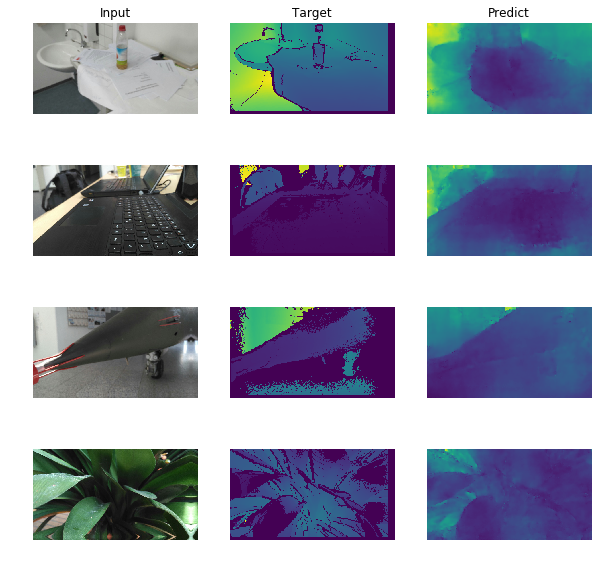

In [9]:
from trainer import loss
from tools.vis_tools import visualize_tensors
from tools import project

import torch
import matplotlib.pyplot as plt
import numpy as np

# eval_data = [input, target, predict]
def visualize_eval(dataset, eval_pred, dof_id=4):
    plt.figure(figsize=(10, 10))
    
    num_samples = 4
    #show_ids = np.random.randint(len(dataset), size=num_samples).tolist()
    show_ids = [4, 10, 13, 17]
    #show_ids = range(num_samples)
    
    data = []
    
    metrics = [torch.nn.MSELoss(), 
               loss.RMSELoss(),
               loss.AccuracyLoss(), 
               loss.BadPixLoss(),
               loss.LogRMSELoss(), 
               loss.AbsRelLoss(), 
               loss.SquaredRelLoss()
              ]
    metrics = [loss.MaskedLoss(m) for m in metrics]
    
    for i in show_ids:
        inputs = dataset[i][0][dof_id]
        targets = dataset[i][1]
        pred = eval_pred[i]
        # pred = 1 / eval_pred[i]
        
        #for metric in metrics:
            #print(metric, metric(pred, targets).numpy())
        
        data.append([inputs, targets, pred])
    
    visualize_tensors(data, ["Input", "Target", "Predict"])

data = project.create_component("data", name=dataset, root_dir=proj_dir("datasets"), data_type=data_type)
    
visualize_eval(data, eval_data["pred"])

In [10]:
"""from common.data_tools import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
"""

"from common.data_tools import visualize_grid\n\n# first (next) parameter should be convolutional\nconv_params = next(model.parameters()).data.cpu().numpy()\ngrid = visualize_grid(conv_params.transpose(0, 2, 3, 1))\nplt.imshow(grid.astype('uint8'))\nplt.axis('off')\nplt.gcf().set_size_inches(10, 10)\nplt.show()\n"